[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtIC-TITECH/b3-proj-2024/blob/main/docs/theme_H.ipynb)

# リプレイメモリによるモデルの忘却防止の評価

0~8の手書き数字データで5エポック学習させたモデルに9の手書き数字データを1エポック学習させます。

Training on classes 0-8...


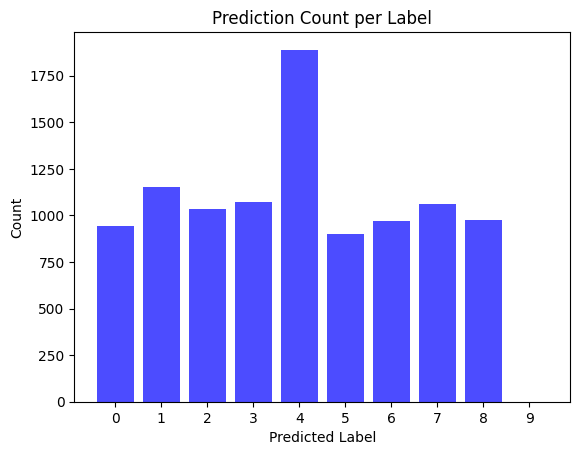

Accuracy before learning class 9: 0.8768


In [1]:
import torch
import copy
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
from collections import deque
import matplotlib.pyplot as plt

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データ変換
transform = transforms.Compose([transforms.ToTensor()])

# データセットのダウンロードと準備
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# クラス 0〜8 のデータのみを抽出
train_indices_0_8 = [i for i, (_, label) in enumerate(train_dataset) if label < 9]
train_dataset_0_8 = Subset(train_dataset, train_indices_0_8)

# クラス 9 のデータのみを抽出
train_indices_9 = [i for i, (_, label) in enumerate(train_dataset) if label == 9]
train_dataset_9 = Subset(train_dataset, train_indices_9)

# データローダの作成
train_loader_0_8 = DataLoader(train_dataset_0_8, batch_size=64, shuffle=True)
train_loader_9 = DataLoader(train_dataset_9, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# シンプルなニューラルネットワークモデル
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# モデル、損失関数、オプティマイザの定義
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# モデルの訓練関数
def train(model, loader, optimizer, criterion, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    label_counts = [0] * 10  # MNISTのラベルは0〜9なので、10個のカウント用リストを準備

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 予測ラベルごとのカウントを更新
            for label in predicted:
                label_counts[label.item()] += 1

    # 精度を計算
    accuracy = correct / total

    # ヒストグラムをプロット
    plt.bar(range(10), label_counts, color='blue', alpha=0.7)
    plt.xlabel('Predicted Label')
    plt.ylabel('Count')
    plt.title('Prediction Count per Label')
    plt.xticks(range(10))  # x軸のラベルを0〜9に設定
    plt.show()

    return accuracy

# リプレイメモリのクラス（画像単位で保存）
class ReplayMemory:
    def __init__(self, max_size):
        self.memory = deque(maxlen=max_size)

    def add(self, image, label):
        self.memory.append((image, label))

    def sample(self, batch_size):
        # 個別の画像をランダムにサンプル
        return random.sample(self.memory, batch_size)

# リプレイメモリのインスタンスを作成
replay_memory = ReplayMemory(5000)

# リプレイメモリを使って訓練する関数（画像単位でサンプル）
def train_with_replay_memory(model, loader, optimizer, criterion, replay_memory=None, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # リプレイメモリから個別の画像をランダムにサンプル
            if replay_memory is not None and len(replay_memory.memory) > 0:
                replay_samples = replay_memory.sample(batch_size=64)  # バッチサイズと同じ枚数
                replay_images, replay_labels = zip(*replay_samples)
                replay_images = torch.stack(replay_images).to(device)
                replay_labels = torch.tensor(replay_labels).to(device)

                # 新しいデータとリプレイメモリからのデータを結合
                combined_images = torch.cat([images, replay_images], dim=0)
                combined_labels = torch.cat([labels, replay_labels], dim=0)
            else:
                combined_images = images
                combined_labels = labels

            outputs = model(combined_images)
            loss = criterion(outputs, combined_labels)
            loss.backward()
            optimizer.step()

            # リプレイメモリに現在の画像を追加
            if replay_memory is not None:
                for img, lbl in zip(images, labels):
                    replay_memory.add(img, lbl)

# ステップ1: クラス 0～8 でモデルを学習
print("Training on classes 0-8...")
train(model, train_loader_0_8, optimizer, criterion, epochs=5)
accuracy_before = evaluate(model, test_loader, device)
print(f"Accuracy before learning class 9: {accuracy_before:.4f}")

# ステップ1で学習したモデルをディープコピー
model_no_replay = copy.deepcopy(model)
model_replay = copy.deepcopy(model)


普通に学習させるとモデルは0~8のデータを分類する方法を忘れてしまいます。

Training on class 9 without replay memory...


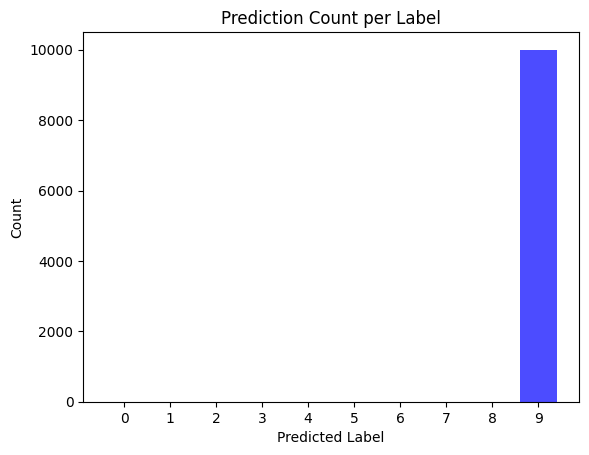

Accuracy after learning class 9 without replay memory: 0.1009


In [2]:
# ステップ2: リプレイメモリなしで、クラス 9 のデータで学習
print("Training on class 9 without replay memory...")
optimizer = optim.SGD(model_no_replay.parameters(), lr=0.1, momentum=0.9)
train(model_no_replay, train_loader_9, optimizer, criterion, epochs=3)
accuracy_after_no_replay = evaluate(model_no_replay, test_loader, device)
print(f"Accuracy after learning class 9 without replay memory: {accuracy_after_no_replay:.4f}")

リプレイメモリを使うことで忘却を防ぐことができます。  
リプレイメモリは0~8の手書き数字を保存しておくメモリで、9の手書き数字を学習する際にその一部を混ぜて学習が行われます。

Training on class 9 with replay memory...


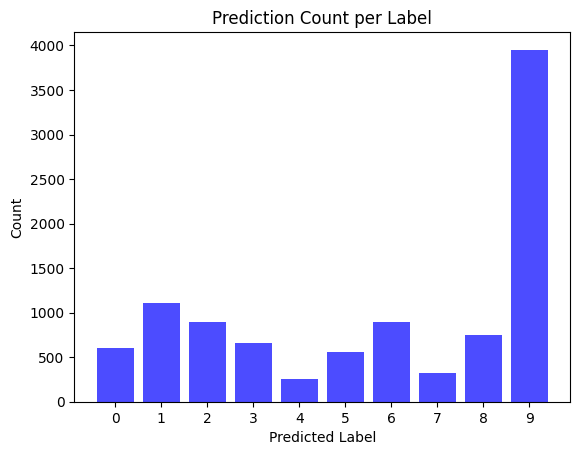

Accuracy after learning class 9 with replay memory: 0.6974


In [3]:
# リプレイメモリにクラス0-8のデータを追加
for images, labels in train_loader_0_8:
    for img, lbl in zip(images, labels):
        replay_memory.add(img, lbl)

# ステップ2: リプレイメモリありで、クラス 9 のデータで学習
print("Training on class 9 with replay memory...")
optimizer = optim.SGD(model_replay.parameters(), lr=0.1, momentum=0.9)
train_with_replay_memory(model_replay, train_loader_9, optimizer, criterion, replay_memory=replay_memory, epochs=1)
accuracy_after_replay = evaluate(model_replay, test_loader, device)
print(f"Accuracy after learning class 9 with replay memory: {accuracy_after_replay:.4f}")